In [79]:
import torch
import fetcher_cpp 

def fetch_tiles_gpu(paths):
    """
    paths: list of str
    returns: torch.FloatTensor [N,3,H,W] on cuda, in [0,1]
    """
    if len(paths) == 0:
        return torch.empty(0, 3, 1, 1, device="cuda", dtype=torch.float32)
    out = fetcher_cpp.decode_batch(paths)
    # ensure type/device as expected
    if out.dtype != torch.float32:
        out = out.float().div_(255.0)
    if not out.is_cuda:
        out = out.cuda(non_blocking=True)
    return out

In [3]:
import pandas as pd
tiles = pd.read_parquet("../data/tcga_luad_lusc/parquet/tiles.parquet")

In [5]:
g = tiles.groupby("slide_id")
first_id = next(iter(g.groups))    # the key of the first group
df_first = g.get_group(first_id)

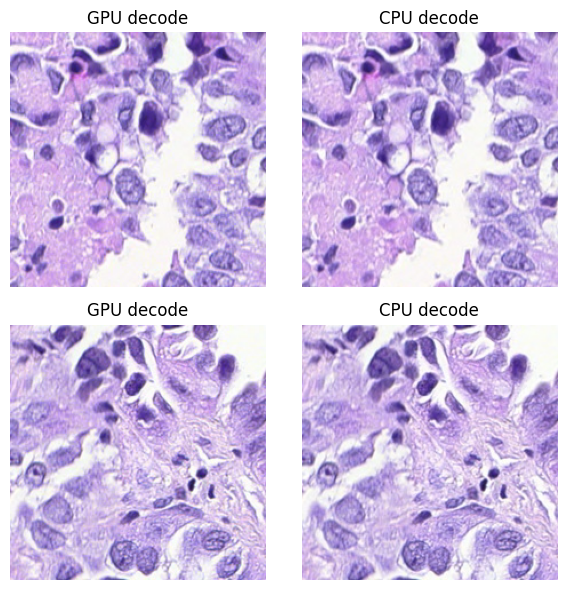

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

paths = df_first.patch_uri.tolist()
paths = paths[2000:2002]

# paths = [...] # your list of 2 paths
tiles_gpu = fetch_tiles_gpu(paths)        # [N,3,H,W] float32 cuda
tiles_gpu_cpu = tiles_gpu.cpu()           # move to CPU

# decode CPU reference images directly from disk (uint8)
tiles_ref = [read_image(p).float() / 255. for p in paths]   # list of [3,H,W]

N = len(paths)
fig, axs = plt.subplots(N, 2, figsize=(6, 3*N))

for i in range(N):
    gpu_img  = to_pil_image(tiles_gpu_cpu[i])         # float32 [3,H,W]
    ref_img  = to_pil_image(tiles_ref[i])             # float32 [3,H,W]

    axs[i,0].imshow(gpu_img)
    axs[i,0].set_title("GPU decode")
    axs[i,0].axis("off")

    axs[i,1].imshow(ref_img)
    axs[i,1].set_title("CPU decode")
    axs[i,1].axis("off")

plt.tight_layout()
plt.show()

In [81]:
paths = df_first.patch_uri.tolist()

paths = paths[:512]

import time 
start = time.time()
tiles_gpu = fetch_tiles_gpu(paths) 
end = time.time()
print(f"Fetched {len(paths)} tiles in {end - start:.2f} seconds")

Fetched 512 tiles in 0.04 seconds
